In [248]:
# Basic usage
import os,sys
from datetime import datetime, timedelta
from dotenv import load_dotenv

# Data processing
import pandas as pd
from pandas import to_datetime
import numpy as np
import csv

print (sys.path)
#vscode usage
sys.path.append(os.path.abspath(os.curdir))

# Customized usage
from dao.BikeStationsDao import BikeStation_api
from dao.CurrentWeatherDao import weather_api
from models.BikeStations import Stations

# Web development
from flask_fontawesome import FontAwesome
from flask import Flask, render_template, request, jsonify
from sqlalchemy import create_engine

# Library Imports.
import matplotlib.pyplot as plt

# Allows plots to appear directly in the notebook.
%matplotlib inline

# training model 
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
import pickle

#Pycharm usage 
#local_path = os.path.abspath(os.curdir)+"/.."
#vs code usage 
local_path = os.path.abspath(os.curdir)

print(local_path)
config_path = local_path+"/.env"
print(config_path)
load_dotenv(config_path)
URI = os.getenv("URI")
PORT = "3306"
PASSWORD = os.getenv("PASSWORD")
DB = os.getenv("DB")
USER = os.getenv("User") # note: USER will get user name of this computer.
mysql_url = "mysql+pymysql://{}:{}@{}:{}/{}".format(USER, PASSWORD, URI, PORT, DB)

['/Users/Hank.Da/Documents/UCD/Semester2/COMP30830-Software Engineering/bike_project/COMP30830_DublinBike', '/Users/Hank.Da/anaconda3/envs/comp30830/lib/python39.zip', '/Users/Hank.Da/anaconda3/envs/comp30830/lib/python3.9', '/Users/Hank.Da/anaconda3/envs/comp30830/lib/python3.9/lib-dynload', '', '/Users/Hank.Da/anaconda3/envs/comp30830/lib/python3.9/site-packages', '/Users/Hank.Da/anaconda3/envs/comp30830/lib/python3.9/site-packages/IPython/extensions', '/Users/Hank.Da/.ipython', '/Users/Hank.Da/Documents/UCD/Semester2/COMP30830-Software Engineering/bike_project/COMP30830_DublinBike', '/Users/Hank.Da/Documents/UCD/Semester2/COMP30830-Software Engineering/bike_project/COMP30830_DublinBike', '/Users/Hank.Da/Documents/UCD/Semester2/COMP30830-Software Engineering/bike_project/COMP30830_DublinBike', '/Users/Hank.Da/Documents/UCD/Semester2/COMP30830-Software Engineering/bike_project/COMP30830_DublinBike', '/Users/Hank.Da/Documents/UCD/Semester2/COMP30830-Software Engineering/bike_project/CO

In [391]:
engine = create_engine(mysql_url, echo=True)
dao_bike = BikeStation_api(engine)

### 0. Read table from RDS and store it to csv file.

In [392]:
def get_station():
    file_name = "stations.csv"
    df = pd.read_sql_query("select * from dbike.stations order by last_update desc",engine)
    df.to_csv(file_name)
get_station()

2021-04-08 09:48:20,124 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-04-08 09:48:20,130 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 09:48:20,228 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-04-08 09:48:20,231 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 09:48:20,423 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-04-08 09:48:20,425 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 09:48:20,621 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8mb4' and `Collation` = 'utf8mb4_bin'
2021-04-08 09:48:20,623 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 09:48:20,733 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-04-08 09:48:20,734 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 09:48:20,828 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-04-08 09:48:20,830 INFO sqlalchemy.engine.base.E

In [393]:
def get_weather():
    file_name = "weather.csv"
    df = pd.read_sql_query("select * from dbike.weather order by current desc",engine)
    df.to_csv(file_name)
get_weather()

2021-04-08 09:48:51,618 INFO sqlalchemy.engine.base.OptionEngine select * from dbike.weather order by current desc
2021-04-08 09:48:51,629 INFO sqlalchemy.engine.base.OptionEngine {}


### 1. Read csv file as dataframe

* df_weather for weather table

* dict_stations for stations table, dict_stations['station_id'] is a dataframe for specific station id

In [432]:
df = pd.read_csv('weather.csv')
del df["Unnamed: 0"]
print(df.shape)
df.head(10)

(7424, 21)


,lat,lon,timezone,current,wether_id,weather_icon,visibility,wind_speed,wind_deg,wind_gust,...,feels_like,temp_min,temp_max,pressure,humidity,rain_1h,snow_1h,sunrise,sunset,description
0,53.344,-6.2672,3600,2021-04-08 08:40:57,803,NaN,NaN,5.14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clouds
1,53.344,-6.2672,3600,2021-04-08 08:39:28,803,04d,10000.0,5.14,240.0,0.0,...,276.73,279.15,280.93,1019.0,81.0,0.0,0.0,2021-04-08 05:41:23,2021-04-08 19:11:57,Clouds
2,53.344,-6.2672,3600,2021-04-08 08:30:02,803,04d,10000.0,5.14,240.0,0.0,...,276.73,279.15,280.93,1019.0,81.0,0.0,0.0,2021-04-08 05:41:23,2021-04-08 19:11:57,Clouds
3,53.344,-6.2672,3600,2021-04-08 08:27:11,803,04d,10000.0,5.14,240.0,0.0,...,276.71,279.15,280.93,1019.0,81.0,0.0,0.0,2021-04-08 05:41:23,2021-04-08 19:11:57,Clouds
4,53.344,-6.2672,3600,2021-04-08 08:19:31,803,NaN,NaN,5.14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clouds
5,53.344,-6.2672,3600,2021-04-08 08:13:32,803,04d,10000.0,4.12,240.0,0.0,...,277.40,279.15,280.93,1019.0,81.0,0.0,0.0,2021-04-08 05:41:23,2021-04-08 19:11:57,Clouds
6,53.344,-6.2672,3600,2021-04-08 08:06:27,803,NaN,NaN,4.12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clouds
7,53.344,-6.2672,3600,2021-04-08 07:55:56,803,04d,10000.0,4.12,240.0,0.0,...,277.29,279.15,281.48,1019.0,81.0,0.0,0.0,2021-04-08 05:41:23,2021-04-08 19:11:57,Clouds
8,53.344,-6.2672,3600,2021-04-08 07:52:23,803,04d,10000.0,4.12,240.0,0.0,...,277.10,279.15,280.93,1019.0,81.0,0.0,0.0,2021-04-08 05:41:23,2021-04-08 19:11:57,Clouds
9,53.344,-6.2672,3600,2021-04-08 07:49:52,803,NaN,NaN,4.12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clouds


In [433]:
df_stations = pd.read_csv('stations.csv')
del df_stations["Unnamed: 0"]
print(df_stations.shape)
df_stations.head(10)

(568389, 9)


,number,name,address,pos_lat,pos_lng,bike_stands,available_bike_stands,available_bikes,last_update
0,100,HEUSTON BRIDGE (SOUTH),Heuston Bridge (South),53.3471,-6.29204,25,12,13,2021-04-08 08:46:24
1,59,DENMARK STREET GREAT,Denmark Street Great,53.3556,-6.26140,20,16,4,2021-04-08 08:46:19
2,95,ROYAL HOSPITAL,Royal Hospital,53.3439,-6.29706,40,32,8,2021-04-08 08:46:12
3,50,GEORGES LANE,George's Lane,53.3502,-6.27970,40,20,20,2021-04-08 08:46:11
4,16,GEORGES QUAY,Georges Quay,53.3475,-6.25219,20,15,5,2021-04-08 08:46:07
5,5,CHARLEMONT PLACE,Charlemont Street,53.3307,-6.26018,40,27,13,2021-04-08 08:46:04
6,110,PHIBSBOROUGH ROAD,Phibsborough Road,53.3563,-6.27372,40,27,12,2021-04-08 08:45:58
7,21,LEINSTER STREET SOUTH,Leinster Street South,53.3422,-6.25449,30,13,17,2021-04-08 08:45:51
8,109,BUCKINGHAM STREET LOWER,Buckingham Street Lower,53.3533,-6.24932,29,13,15,2021-04-08 08:45:36
9,22,TOWNSEND STREET,Townsend Street,53.3459,-6.25461,20,7,12,2021-04-08 08:45:27


* Seperate stations dataframe to specific station table, and filter interested columns. 
* Set last_update as index.

In [434]:
stations_id = df_stations["number"].unique()
# print("stations id", stations_id)

stations_feature_column = ["last_update","number","bike_stands","available_bikes"]

dict_stations = {}

for id in stations_id:
    dict_stations[id] = df_stations.loc[df_stations['number'] == id][stations_feature_column].sort_values('last_update')
    

df_station36 = dict_stations[36]
df_station36['last_update'] = pd.to_datetime(df_station36['last_update'])
# converting this to the index so we can preserve the date_start_time columns so you can validate the merging logic
df_station36= df_station36.set_index('last_update')

print("shape of station36: ", df_station36.shape)
df_station36.head()

shape of station36:  (5109, 3)


,number,bike_stands,available_bikes
last_update,,,
2021-03-05 13:46:42,36,40,6
2021-03-05 13:56:48,36,40,6
2021-03-05 14:08:54,36,40,5
2021-03-05 14:18:49,36,40,6
2021-03-05 14:28:55,36,40,6


* Seperate stations dataframe to specific station table, and filter out not interested columns. 

In [435]:
feature_column = ["current","feels_like","humidity","wind_speed","wether_id"]
# df_weather = df[feature_column]
df_weather = df
df_weather = df_weather.rename(columns={'current': 'last_update'})
df_weather = df_weather.sort_values('last_update')
df_weather['last_update'] = pd.to_datetime(df_weather['last_update'])
df_weather = df_weather.set_index('last_update')

print("shape of df_weather: ", df_weather.shape)
df_weather.head()

shape of df_weather:  (7424, 20)


,lat,lon,timezone,wether_id,weather_icon,visibility,wind_speed,wind_deg,wind_gust,temperature,feels_like,temp_min,temp_max,pressure,humidity,rain_1h,snow_1h,sunrise,sunset,description
last_update,,,,,,,,,,,,,,,,,,,,
2021-03-05 13:41:13,53.344,-6.2672,0,803,04d,10000.0,3.60,130.0,0.0,278.26,273.62,277.59,278.71,1034.0,65.0,0.0,0.0,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds
2021-03-05 13:51:08,53.344,-6.2672,0,803,NaN,NaN,3.09,NaN,NaN,278.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clouds
2021-03-05 13:52:22,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.35,273.94,277.59,278.71,1034.0,60.0,0.0,0.0,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds
2021-03-05 14:04:48,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.26,273.84,277.59,278.71,1034.0,60.0,0.0,0.0,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds
2021-03-05 14:05:10,53.344,-6.2672,0,803,NaN,NaN,3.09,NaN,NaN,278.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clouds


### 2. Drop columns with nan value

In [436]:
df_weather = df_weather.dropna()
df_station36 = df_station36.dropna()

print("shape of df_weather: ", df_weather.shape)
print("shape of station36: ", df_station36.shape)


shape of df_weather:  (3734, 20)
shape of station36:  (5109, 3)


### 3. Merge weather and stations dataframe by index (last_update).

In [437]:
# Merge two dataframe by last update with torlerance
tol = pd.Timedelta('5 minute')
df_station36_features = pd.merge_asof(left=df_weather,right=df_station36,right_index=True,left_index=True,direction='nearest',tolerance=tol)

df_station36_features = df_station36_features.dropna()
df_station36_features.head()

,lat,lon,timezone,wether_id,weather_icon,visibility,wind_speed,wind_deg,wind_gust,temperature,...,pressure,humidity,rain_1h,snow_1h,sunrise,sunset,description,number,bike_stands,available_bikes
last_update,,,,,,,,,,,,,,,,,,,,,
2021-03-05 13:52:22,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.35,...,1034.0,60.0,0.0,0.0,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,6.0
2021-03-05 14:04:48,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.26,...,1034.0,60.0,0.0,0.0,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,5.0
2021-03-05 14:14:48,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.26,...,1034.0,60.0,0.0,0.0,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,6.0
2021-03-05 14:29:08,53.344,-6.2672,0,803,04d,10000.0,4.63,110.0,0.0,278.26,...,1034.0,56.0,0.0,0.0,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,6.0
2021-03-05 14:44:49,53.344,-6.2672,0,803,04d,10000.0,3.60,140.0,0.0,278.35,...,1034.0,56.0,0.0,0.0,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,5.0


### 4. Separate df_station36_features by weekday and weekend, so each station will has two models.

In [438]:
'''Remove outlier before training'''
def remove_outlier(df):    
    df = df[np.abs(df["available_bike_ratio"]-df["available_bike_ratio"].mean())<=(3*df["available_bike_ratio"].std())]
    return df

In [439]:
df_station36_features['date'] = pd.to_datetime(df_station36_features.index, format='%Y-%m-%d', errors='ignore')

# day_of_week, 0 stands for Mon, 6 stands for Sat
df_station36_features['day_of_week'] = pd.to_datetime(df_station36_features.index, format='%Y-%m-%d', errors='ignore').dt.dayofweek
df_station36_features['time'] = [d.time() for d in df_station36_features.index]
# period = hour*6 + round(min/10)
df_station36_features['period'] = df_station36_features.apply(lambda x: (int(round(x["time"].minute/10)) + x["time"].hour*6), axis=1)
df_station36_features['available_bike_ratio'] = (df_station36_features['available_bikes'] / df_station36_features['bike_stands'],1)
df_station36_features_clean = remove_outlier(df_station36_features)

print("shape of df_station36_features: ", df_station36_features.shape)
print("shape df_station36_features_clean: ", df_station36_features_clean.shape)

df_station36_features_clean.to_csv("station36.csv")
df_station36_features.describe()

ValueError: Length of values (2) does not match length of index (3644)

In [421]:
del df_station36_features['date']

df_station36_features.head()

,lat,lon,timezone,wether_id,weather_icon,visibility,wind_speed,wind_deg,wind_gust,temperature,...,sunrise,sunset,description,number,bike_stands,available_bikes,day_of_week,time,period,available_bike_ratio
last_update,,,,,,,,,,,,,,,,,,,,,
2021-03-05 13:52:22,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.35,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,6.0,4,13:52:22,83,20.0
2021-03-05 14:04:48,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.26,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,5.0,4,14:04:48,84,10.0
2021-03-05 14:14:48,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.26,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,6.0,4,14:14:48,85,20.0
2021-03-05 14:29:08,53.344,-6.2672,0,803,04d,10000.0,4.63,110.0,0.0,278.26,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,6.0,4,14:29:08,87,20.0
2021-03-05 14:44:49,53.344,-6.2672,0,803,04d,10000.0,3.60,140.0,0.0,278.35,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,5.0,4,14:44:49,88,10.0


In [422]:
# Look at correlations for all the continuous features.
df_station36_features.corr().available_bike_ratio

lat                          NaN
lon                          NaN
timezone               -0.113305
wether_id              -0.061925
visibility              0.011521
wind_speed              0.155302
wind_deg                0.150773
wind_gust              -0.129232
temperature             0.074234
feels_like              0.016570
temp_min                0.079161
temp_max                0.059051
pressure               -0.036899
humidity               -0.051579
rain_1h                      NaN
snow_1h                      NaN
number                       NaN
bike_stands                  NaN
available_bikes         0.976712
day_of_week            -0.208206
period                  0.032724
available_bike_ratio    1.000000
Name: available_bike_ratio, dtype: float64

In [407]:
df_weekDay = df_station36_features[(df_station36_features['day_of_week'] <= 3) & (df_station36_features['period'] >= 36)]
df_weekEnd = df_station36_features[(df_station36_features['day_of_week'] >3) & (df_station36_features['period'] >= 36)]

print(df_weekDay.corr().available_bike_ratio)
print("\n")
print(df_weekEnd.corr().available_bike_ratio)

df_weekDay.reset_index(drop=True)
df_weekEnd.reset_index(drop=True)

lat                          NaN
lon                          NaN
timezone               -0.160446
wether_id              -0.034663
visibility              0.069718
wind_speed             -0.058249
wind_deg                0.153262
wind_gust              -0.212306
temperature            -0.071178
feels_like             -0.043354
temp_min               -0.096937
temp_max               -0.053057
pressure                0.257309
humidity               -0.065916
rain_1h                      NaN
snow_1h                      NaN
number                       NaN
bike_stands                  NaN
available_bikes         0.964189
day_of_week             0.184905
period                 -0.284404
available_bike_ratio    1.000000
Name: available_bike_ratio, dtype: float64


lat                          NaN
lon                          NaN
timezone               -0.129728
wether_id              -0.047206
visibility              0.084578
wind_speed              0.323109
wind_deg                0.14737

,lat,lon,timezone,wether_id,weather_icon,visibility,wind_speed,wind_deg,wind_gust,temperature,...,sunrise,sunset,description,number,bike_stands,available_bikes,day_of_week,time,period,available_bike_ratio
0,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.35,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,6.0,4,13:52:22,83,20.0
1,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.26,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,5.0,4,14:04:48,84,10.0
2,53.344,-6.2672,0,803,04d,10000.0,3.09,140.0,0.0,278.26,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,6.0,4,14:14:48,85,20.0
3,53.344,-6.2672,0,803,04d,10000.0,4.63,110.0,0.0,278.26,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,6.0,4,14:29:08,87,20.0
4,53.344,-6.2672,0,803,04d,10000.0,3.60,140.0,0.0,278.35,...,2021-03-05 07:03:21,2021-03-05 18:10:03,Clouds,36.0,40.0,5.0,4,14:44:49,88,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,53.344,-6.2672,3600,803,04n,10000.0,9.26,280.0,0.0,281.38,...,2021-04-05 05:48:31,2021-04-05 19:06:32,Clouds,36.0,40.0,7.0,6,23:17:13,140,20.0
1205,53.344,-6.2672,3600,803,04n,10000.0,9.26,280.0,0.0,281.29,...,2021-04-05 05:48:31,2021-04-05 19:06:32,Clouds,36.0,40.0,7.0,6,23:33:22,141,20.0
1206,53.344,-6.2672,3600,803,04n,10000.0,9.26,280.0,0.0,281.29,...,2021-04-05 05:48:31,2021-04-05 19:06:32,Clouds,36.0,40.0,7.0,6,23:36:27,142,20.0
1207,53.344,-6.2672,3600,803,04n,10000.0,8.23,280.0,0.0,281.42,...,2021-04-05 05:48:31,2021-04-05 19:06:32,Clouds,36.0,40.0,7.0,6,23:51:27,143,20.0


### 5. Generate test and training set to evaluate and train model

In [408]:
# Prepare the descriptive features
#print(df.head(10))

# chose the features with correlation greater than 0.1
features_weekDay = ['day_of_week',"period"]
features_weekEnd = ['wind_speed','pressure']
X_1 = df_weekDay[features_weekDay]
Y_1 = df_weekDay.available_bike_ratio

X_2 = df_weekEnd[features_weekEnd]
Y_2 = df_weekEnd.available_bike_ratio

test_size = 0.33
seed = 7

X_1_train, X_1_test, Y_1_train, Y_1_test = train_test_split(X_1, Y_1, test_size=test_size, random_state=seed)
X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_2, test_size=test_size, random_state=seed)

In [410]:
# Train a model using linear regression from scikit-learn.
# By default sklearn fits an intercept.
# Use only the descriptive feature Size.
linreg1 = LinearRegression().fit(X_1_train[features_weekDay], Y_1_train)
linreg2 = LinearRegression().fit(X_2_train[features_weekEnd], Y_2_train)

# save the model to disk
filename_1 = 'station_36_weekDay_'+datetime.today().strftime('%Y-%m-%d')+'.sav'
filename_2 = 'station_36_weekEnd_'+datetime.today().strftime('%Y-%m-%d')+'.sav'

pickle.dump(linreg1, open(filename_1, 'wb'))
pickle.dump(linreg2, open(filename_2, 'wb'))

In [411]:
# Print the estimated linear regression coefficients.
print("Features: \n", features_weekDay)
print("Coeficients: \n", linreg1.coef_)
print("\nIntercept: \n", linreg1.intercept_)

# Print the estimated linear regression coefficients.
print("Features: \n", features_weekEnd)
print("Coeficients: \n", linreg2.coef_)
print("\nIntercept: \n", linreg2.intercept_)

Features: 
 ['day_of_week', 'period']
Coeficients: 
 [ 1.87538648 -0.10463077]

Intercept: 
 35.7995173552312
Features: 
 ['wind_speed', 'pressure']
Coeficients: 
 [ 0.72633962 -0.21865749]

Intercept: 
 239.35265265599173


#### Evaluate model by test set.

In [415]:
linreg_predictions1 = linreg1.predict(X_1_test[features_weekDay])
linreg_predictions2 = linreg2.predict(X_2_test[features_weekEnd])

print("\nPredictions with linear regression (weekday): \n")
actual_vs_predicted_linreg1 = pd.concat([Y_1_test, pd.DataFrame(linreg_predictions1, columns=['Predicted'], index=Y_1_test.index)], axis=1)
print(actual_vs_predicted_linreg1)


print("\nPredictions with linear regression (weekend): \n")
actual_vs_predicted_linreg2 = pd.concat([Y_2_test, pd.DataFrame(linreg_predictions2, columns=['Predicted'], index=Y_2_test.index)], axis=1)
print(actual_vs_predicted_linreg2)


Predictions with linear regression (weekday): 

                     available_bike_ratio  Predicted
last_update                                         
2021-03-15 12:14:06                  40.0  28.161471
2021-03-29 19:45:05                   0.0  23.453086
2021-04-05 08:58:58                  20.0  30.149456
2021-03-08 18:51:38                  30.0  23.976240
2021-03-31 07:19:06                  30.0  34.946536
...                                   ...        ...
2021-03-30 20:44:09                  10.0  24.700688
2021-04-07 18:34:50                  20.0  27.936274
2021-03-23 06:46:06                  20.0  33.385042
2021-03-15 12:48:40                  40.0  27.742948
2021-03-25 13:46:50                  30.0  32.741323

[504 rows x 2 columns]

Predictions with linear regression (weekend): 

                     available_bike_ratio  Predicted
last_update                                         
2021-03-14 15:34:12                  30.0  24.578519
2021-03-21 22:34:04           

In [424]:
linreg1.score(X_1_test,Y_1_test)

0.13491073712922286

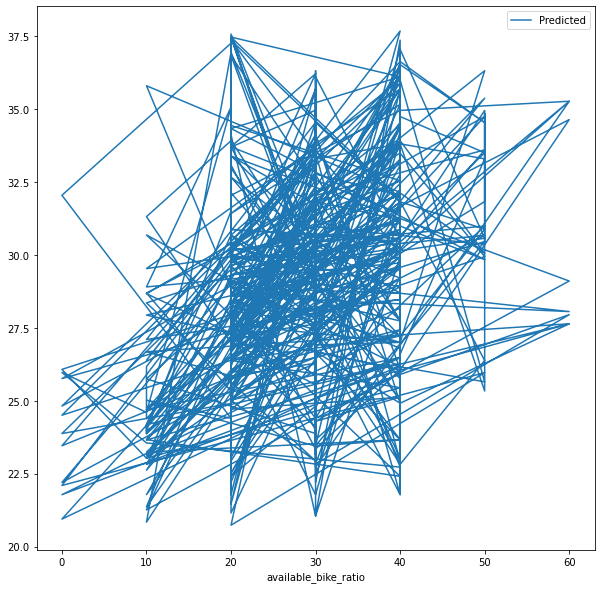

In [416]:
actual_vs_predicted_linreg1.plot(x="available_bike_ratio", y="Predicted", kind="line",figsize=(10,10))
plt.show()

In [417]:
#Pair the actual and the predicted values
#This can be done directly with sklearn functions, but below is a manual example to understand how it works
prediction_errors_1 = Y_1_test - linreg_predictions1
print("Actual - Predicted:\n", prediction_errors_1)
print("\n(Actual - Predicted) squared:\n", prediction_errors_1**2)
print("\n Sum of (Actual - Predicted) squared:\n", (prediction_errors_1**2).sum())

# Print the Mean Squared Error of the model on the training set
mse = (prediction_errors_1** 2).mean()
rmse = ((prediction_errors_1** 2).mean())**0.5

print("\nMean Squared Error:\n", mse)
print("\nRoot Mean Squared Error:\n", rmse)

print("|Actual - Predicted|:\n", abs(prediction_errors_1))

# Print the Mean Absolute Error of the model on the training set
mae = abs(prediction_errors_1).mean()
print("\nMean Absolute Error:\n", mae)

Actual - Predicted:
 last_update
2021-03-15 12:14:06    11.838529
2021-03-29 19:45:05   -23.453086
2021-04-05 08:58:58   -10.149456
2021-03-08 18:51:38     6.023760
2021-03-31 07:19:06    -4.946536
                         ...    
2021-03-30 20:44:09   -14.700688
2021-04-07 18:34:50    -7.936274
2021-03-23 06:46:06   -13.385042
2021-03-15 12:48:40    12.257052
2021-03-25 13:46:50    -2.741323
Name: available_bike_ratio, Length: 504, dtype: float64

(Actual - Predicted) squared:
 last_update
2021-03-15 12:14:06    140.150773
2021-03-29 19:45:05    550.047241
2021-04-05 08:58:58    103.011448
2021-03-08 18:51:38     36.285687
2021-03-31 07:19:06     24.468221
                          ...    
2021-03-30 20:44:09    216.110221
2021-04-07 18:34:50     62.984450
2021-03-23 06:46:06    179.159351
2021-03-15 12:48:40    150.235331
2021-03-25 13:46:50      7.514849
Name: available_bike_ratio, Length: 504, dtype: float64

 Sum of (Actual - Predicted) squared:
 61246.7750089959

Mean Squared Err